In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data import *
from features import *
from stats import *
from preprocess import *
from model import *
from step import *
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
step = Step(load_odr)
# step = Step(load_mnm_spatial)
step = Step(gt_n_trials, step, n=8)
# step = Step(subset, step, key='phase', value='POST')
# step = Step(subset, step, key='monkey', value='ELV')
# step = Step(subset, step, key='subregion', value='MD')
step = Step(subset, step, key='monkey', value='LEM')
step = Step(win_cts_by_trial, step, win_start=1500, win_end=3000, win_stride=150, win_size=150)
# step = Step(win_cts_by_trial, step, win_start=1500, win_end=5000, win_stride=150, win_size=150)
step = Step(win_cts_by_win, step)

In [5]:
cells = step()['cells']
wcbt = step()['win_cts_by_trial']

for c, _ in cells.iterrows():
    # print(c)
    data = wcbt.loc[c].reset_index()
    # print(data)
    lr = sklearn.linear_model.LogisticRegression()
    cts = np.stack(data.win_cts.array)
    cts = cts - cts.mean(axis=0)
    s = cts.std(axis=0)
    s[s == 0] = 1
    cts = cts / s
    lr.fit(cts, data.position)
    yhat = lr.predict(cts)
    data['delta'] = np.abs(data.position - yhat)
    data.delta = np.min(np.vstack([data.delta, 8 - data.delta]), axis=0)
    deltas = data.groupby('position').delta.mean()
    cells.loc[c, 'best_pos'] = deltas.idxmin()
    cells.loc[c, 'best_delta'] = deltas.min()


In [6]:
CELLS_PER_POS = 20
best_cells = cells.sort_values('best_delta').groupby('best_pos').head(CELLS_PER_POS).sort_values(['best_pos', 'best_delta'])

In [7]:
best_cells[best_cells.best_pos == 5].index.get_level_values('cell').values

array(['LEM-PFC-259', 'LEM-PFC-260', 'LEM-PFC-067', 'LEM-PFC-258',
       'LEM-PFC-159', 'LEM-PFC-268', 'LEM-PFC-266', 'LEM-PFC-166',
       'LEM-PPC-087', 'LEM-PFC-014', 'LEM-PFC-244', 'LEM-PFC-167',
       'LEM-PFC-029', 'LEM-PPC-055', 'LEM-PPC-054', 'LEM-PPC-053',
       'LEM-PPC-051', 'LEM-PFC-246', 'LEM-PFC-105', 'LEM-PFC-083'],
      dtype=object)

In [8]:
best_cells[best_cells.best_pos == 3].index.get_level_values('cell').values

array(['LEM-PFC-069', 'LEM-PFC-257', 'LEM-PFC-127', 'LEM-PFC-280',
       'LEM-PFC-282', 'LEM-PFC-283', 'LEM-PFC-284', 'LEM-PFC-287',
       'LEM-PFC-288', 'LEM-PFC-245', 'LEM-PPC-052', 'LEM-PFC-068',
       'LEM-PFC-148', 'LEM-PFC-150', 'LEM-PFC-250', 'LEM-PFC-149',
       'LEM-PFC-170', 'LEM-PFC-310', 'LEM-PFC-049', 'LEM-PFC-289'],
      dtype=object)

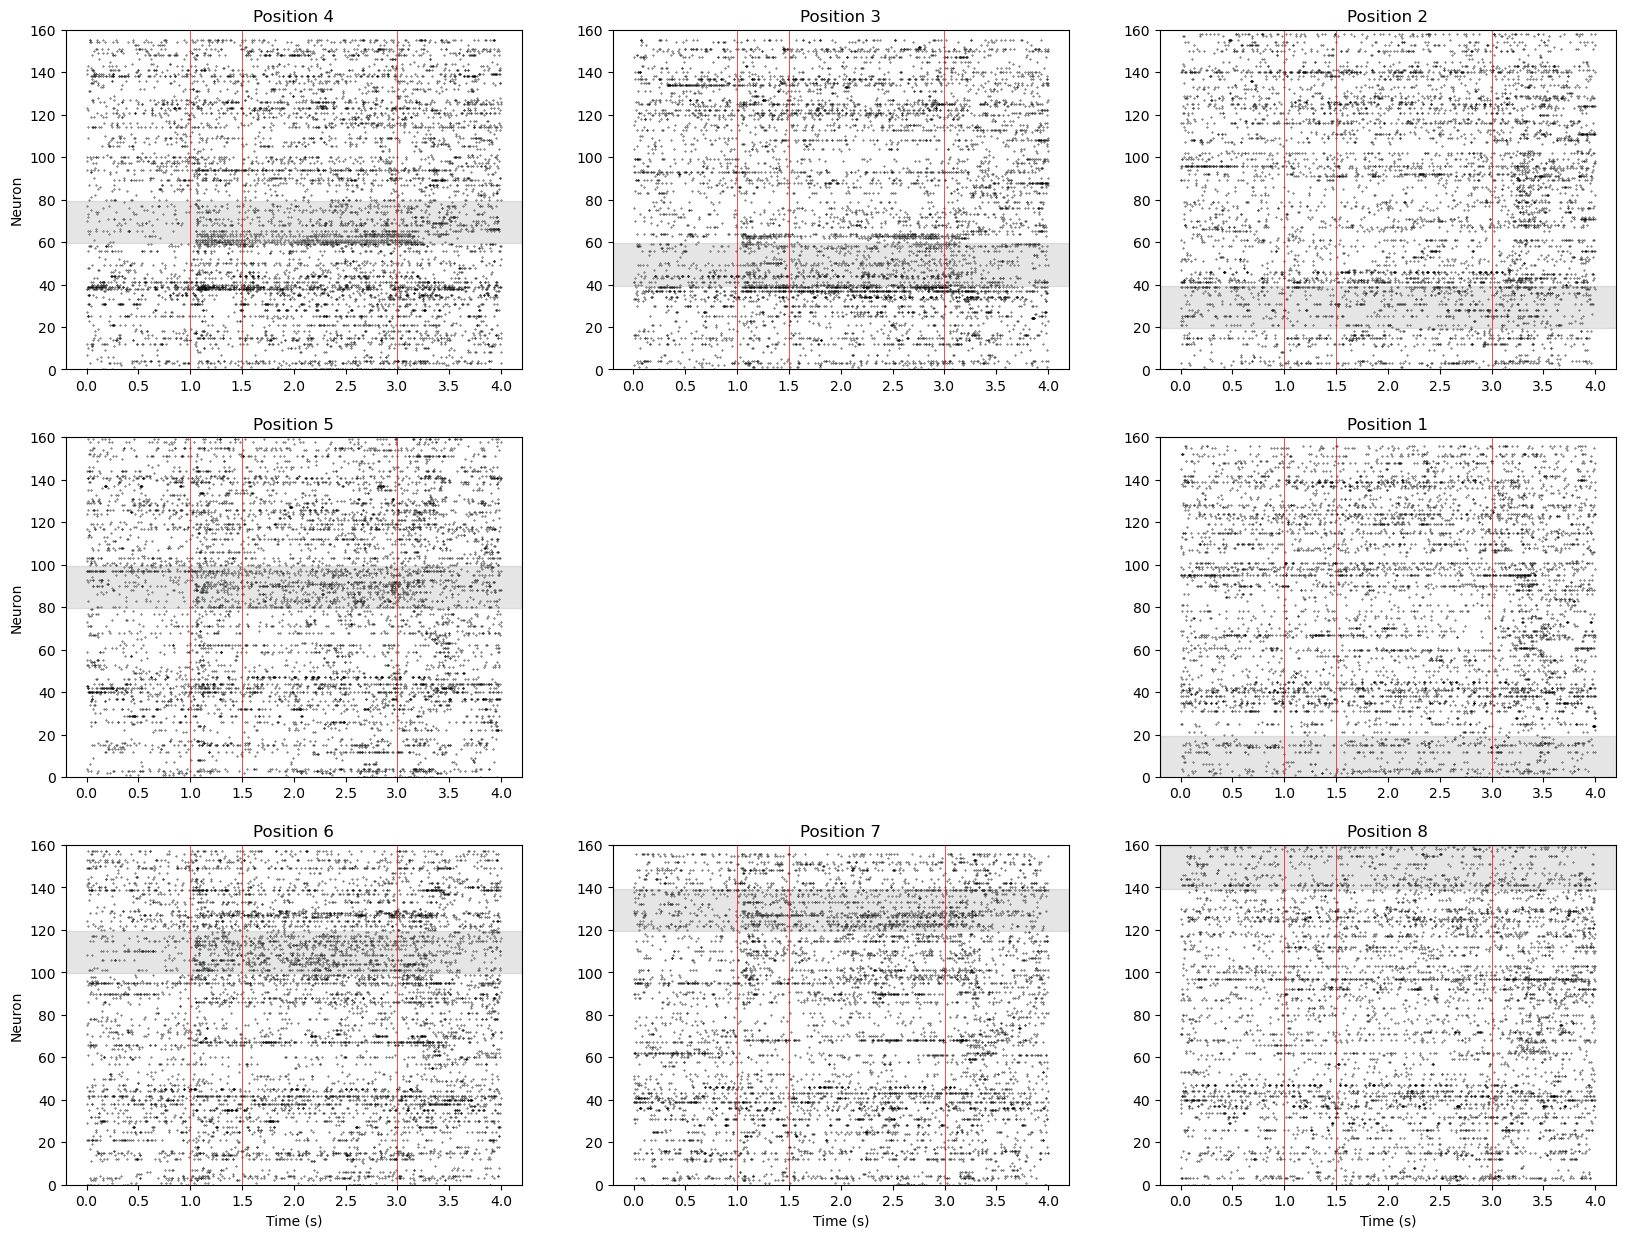

: 

In [17]:
raw_df = step()['raw_df']
raw_df = raw_df.loc[best_cells.index]

rows_and_cols = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for j in range(8):
    r, c = rows_and_cols[j]
    for i, t in enumerate(raw_df.loc[:, j, 0].ts.array):
        ax[r, c].scatter(t, np.ones_like(t) * i, c='k', s=0.1)
    ax[r, c].axhspan(-0.5 + CELLS_PER_POS * j, -0.5 + (1 + j) * CELLS_PER_POS, color='gray', alpha=0.2)
    [ax[r, c].axvline(x=x, color='r', linewidth=0.5) for x in [1.0, 1.5, 3.0]]
    ax[r, c].set_title(f'Position {j + 1}')
    ax[r, c].set_ylim(0, 8 * CELLS_PER_POS)

ax[1, 1].remove()
[ax[i, 0].set_ylabel('Neuron') for i in range(3)]
[ax[2, i].set_xlabel('Time (s)') for i in range(3)]
plt.show()